# Sheet 1: Error Propagation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from resample.bootstrap import variance

# create instance of pseudo-random number generator with fixed seed = 1
rng = np.random.default_rng(seed=1)

---

## Task 1: Error Propagation
Consider the function $y = f(x)$, $y = 1 + a_1x + a_2x^2$ with parameters $a_1 = 2.0 ± 0.2$, $a_2 = 1.0 ± 0.1$ and correlation coefficient $ρ = −0.8$.

### 1.1

Write down the covariance matrix for $a_1$ and $a_2$.

---

The covariance matrix is

$$
\mathrm{Cov}(a) = \begin{pmatrix}\sigma^2_{a_1} & \rho\sigma_{a_1}\sigma_{a_2} \\
                                               \rho\sigma_{a_1}\sigma_{a_2} & \sigma^2_{a_2}
                    \end{pmatrix}
$$

In [2]:
a1, a1_err = 2.0, 0.2
a2, a2_err = 1.0, 0.1
rho = -0.8

c12 = rho * a1_err * a2_err
cov_a = np.array([[a1_err**2, c12], [c12, a2_err**2]])
cov_a

array([[ 0.04 , -0.016],
       [-0.016,  0.01 ]])

---
### 1.2
Compute the uncertainty of $y$ analytically using error propagation. 

---

We first compute derivatives of $y$ by $a_1$ and $a_2$

$$\frac{\partial{}y}{\partial{}a_1} = x \qquad \frac{\partial{}y}{\partial{}a_2} = x^2 \,.$$

We then apply the generic propagation formula using the Jacobi matrix and covariance matrix of inputs. Since the output of $f(x)$ is one-dimensional, the Jacobi matrix is reduced to a vector and the covariance matrix of $y$ is a scalar equal to the standard deviation squared,

$$\sigma^2_y = \mathrm{Cov}(y) = \sum_{ij}\frac{\partial{}y}{\partial{}a_i}\frac{\partial{}y}{\partial{}a_j}\mathrm{Cov}(a)_{ij} \,.$$

Inserting the covariance matrix of $a_1$ and $a_2$ yields

$$\sigma^2_y = c_{11}x^2 + 2c_{12}x^3 + c_{22}x^4 \,,$$

where the $c_{ij}$ are the entries of $\mathrm{Cov}(a)$. The expression can be simplified to:

$$\sigma^2_y = x^2\left(\sigma^2_{a_1} + \sigma^2_{a_2}x^2 + 2\rho\sigma_{a_1}\sigma_{a_2}x\right) \,.$$

Taking the square root:

$$ \sigma_y = \lvert{}x\rvert\sqrt{\sigma^2_{a_1} + \sigma^2_{a_2}x^2 + 2\rho\sigma_{a_1}\sigma_{a_2}x} \,.$$

---
### 1.3

Compare the numerical result for $\sigma_y$ for the two cases where you a) ignore the correlation $\rho$ by setting it to zero, and b) correctly include the correlation. Compute $\sigma_y$ for $x \in [-3, 3]$ and plot the results.

In practice, correlations are often unknown. Is it conservative to set the correlation to zero? A conservative error estimate is always larger than the exact error.

---

In [3]:
def compute_y(x, a1, a2):
    return 1 + a1 * x + a2 * x**2


def compute_err_y_no_correlation(x):
    return np.abs(x) * np.sqrt(cov_a[0, 0] + cov_a[1, 1] * x**2)


def compute_err_y(x):
    return np.abs(x) * np.sqrt(cov_a[0, 0] + cov_a[1, 1] * x**2 + 2 * cov_a[0, 1] * x)

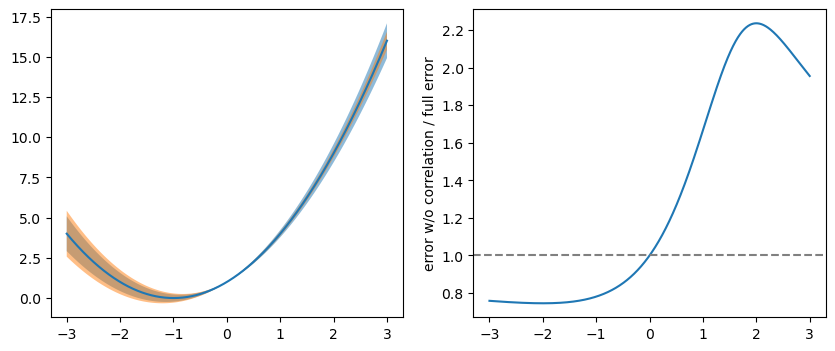

In [4]:
xs = np.linspace(-3, 3, 1000)

# element-wise computation here, since we use numpy arrays

ys = compute_y(xs, a1, a2)
errs_nc = compute_err_y_no_correlation(xs)
errs = compute_err_y(xs)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

plt.sca(ax[0])
plt.plot(xs, ys)
plt.fill_between(xs, ys - errs_nc, ys + errs_nc, alpha=0.5)
plt.fill_between(xs, ys - errs, ys + errs, alpha=0.5)

plt.sca(ax[1])
plt.plot(xs, errs_nc / errs)
plt.axhline(1, ls="--", color="0.5")
plt.ylabel("error w/o correlation / full error");

Setting an unknown correlation to zero does not produce a conservative estimate of the error in general. We see in this particular example that setting the correlation to zero is only conservative for $x > 0$, but the true error on $y$ is underestimated for $x < 0$.

---
### 1.4
Compute the uncertainty of $y$ numerically using Monte-Carlo simulation under the assumption that $a_1$ and $a_2$ are normally distributed.

Generate pairs $(a_{1,i}, a_{2,i})$ from the given values of $a_1$ and $a_2$ and their covariance matrix and visualize these pairs with a scatter plot or 2D histogram.

Use `help(rng)` and make yourself familiar with the available methods to draw random numbers from a variety of statistical distributions. Locate a method that generates correlated normally distributed numbers directly.

---

In [5]:
# help(rng)

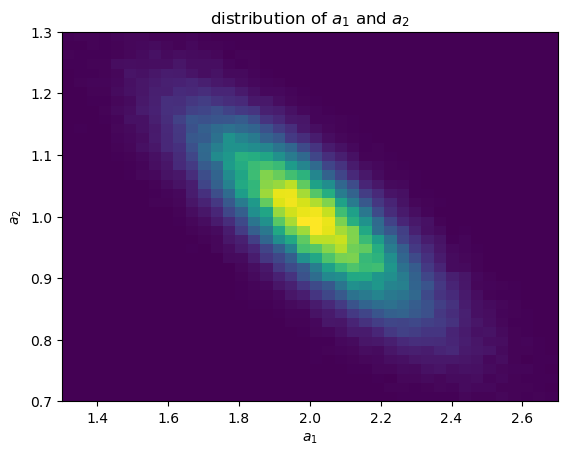

In [6]:
a1s, a2s = rng.multivariate_normal((a1, a2), cov_a, size=(100_000)).T
plt.figure()
plt.hist2d(a1s, a2s, range=((1.3, 2.7), (0.7, 1.3)), bins=40)
plt.title("distribution of $a_1$ and $a_2$")
plt.xlabel("$a_1$")
plt.ylabel("$a_2$");

---

### 1.5

Determine the distribution of $y_i$-samples for $x = \{-1, 0, +1\}$ and compare their mean and variance with the results of the analytical calculation.

---

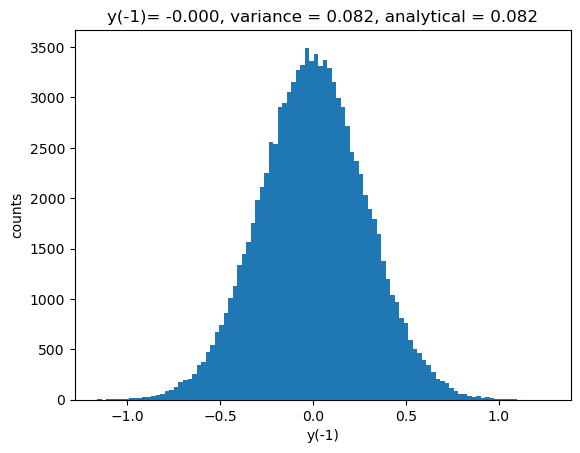

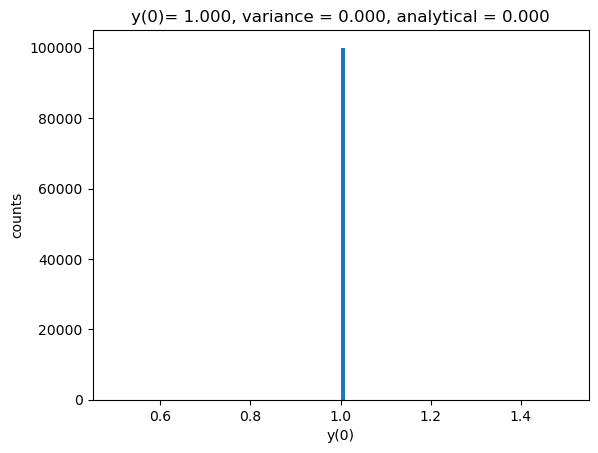

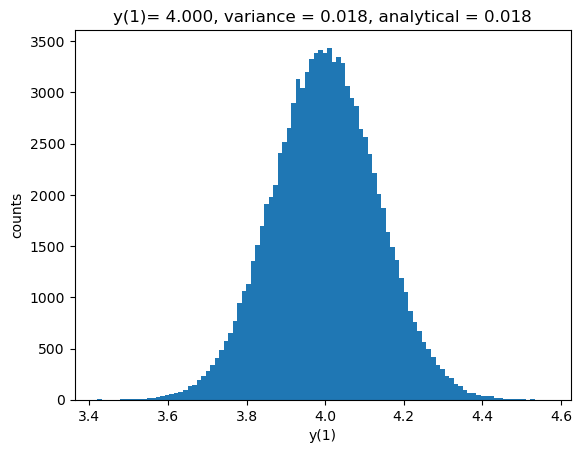

In [7]:
# we previously computed y and err_y in 1.2.2

for x in (-1, 0, 1):
    # a1s, a2s are the Gaussian distributions from before
    ys = compute_y(x, a1s, a2s)
    mean = np.mean(ys)
    var = np.var(ys)
    plt.figure()
    plt.hist(ys, bins=100)
    plt.xlabel(f"y({x})")
    plt.ylabel("counts")
    plt.title(
        f"y({x})= {mean:.3f}, "
        f"variance = {var:.3f}, "
        f"analytical = {compute_err_y(x)**2:.3f}"
    )

The case $x = 0$ is special here. Since all coefficients precede powers of $x$, the case always yields $y=0$ regardless of the $a_i$.

---

## Task 2: Error Propagation with Transformation
Now consider the following reparametrisation of $y = f(x)$:
    
$$y = 1 + \frac{x(1+x)}{b_1} + \frac{x(1-x)}{b_2}$$

### 2.1
Determine analytically the transformed parameters $b_1$ and $b_2$ and their covariance matrices.

---

The transformed covariance matrix is $\mathrm{Cov}(b) = J \,\mathrm{Cov}(a) \, J^T$, where $J$ is the Jacobi matrix containing the derivatives of the new parameters as a function of the old parameters.

We first express the $b_i$ as function of the $a_i$. Here we can neglect the term $+1$ because it occurs equally in both definitions.

\begin{align}
 a_1 x + a_2 x^2 &= \frac{x(1 + x)}{b_1} + \frac{x(1 - x)}{b_2} \\
                 &= \frac{x}{b_1} + \frac{x^2}{b_1} + \frac{x}{b_2} - \frac{x^2}{b_2} \\
                 &= x\left(\frac{1}{b_1} + \frac{1}{b_2}\right) + x^2\left(\frac{1}{b_1} - \frac{1}{b_2}\right) \,.
\end{align}

Thus

$$a_1 = \left(\frac{1}{b_1} + \frac{1}{b_2}\right) \quad\text{and}\quad a_2 = \left(\frac{1}{b_1} - \frac{1}{b_2}\right)$$

and

$$b_1 = \frac{2}{a_1 + a_2} \quad \text{and} \quad b_2 = \frac{2}{a_1 - a_2} \,.$$

For the Jacobian matrix of the transformation we get

\begin{equation}
    J = \begin{pmatrix}
        \frac{-2}{(a_1 + a_2)^2} & \frac{-2}{(a_1 + a_2)^2} \\
        \frac{-2}{(a_1 - a_2)^2} & \frac{+2}{(a_1 - a_2)^2}      
    \end{pmatrix} \quad \text{where} \quad J_{ij} = \frac{\partial b_i}{\partial a_j} \, .
\end{equation}

In [8]:
def trafo(a):
    a1, a2 = a
    b1 = 2 / (a1 + a2)
    b2 = 2 / (a1 - a2)
    return np.array([b1, b2])


denom1 = (a1 + a2) ** 2
denom2 = (a1 - a2) ** 2

J = np.array([[-2 / denom1, -2 / denom1], [-2 / denom2, 2 / denom2]])
cov_b = J @ cov_a @ J.T

trafo((a1, a2)), cov_b

(array([0.66666667, 2.        ]),
 array([[0.00088889, 0.01333333],
        [0.01333333, 0.328     ]]))